We extract stats for the following corpora

# EHRs
**Cardiology**
* [x] CarTeksten
* [x] SCAD
* [x] DataTools4Heart
* [x] DIGIN
* [x] PobTriage
* ARGUS
* [/] CCN
* [x] HMC

**IBD**
* MDL_hackathon $\rightarrow$ prefix with 'IBD_'

**Kidney**
* [x] ODIN  $\rightarrow$ prefix with 'NEFRO_'

**RA**
* D2TRA hackathon  $\rightarrow$ prefix with 'RA_'
* STRATAFIT $\rightarrow$ prefix with 'RA_'

# Other

* NtvG  $\rightarrow$ prefix with 'GEN_'
* HenW $\rightarrow$ prefix with 'GEN_'
* NHG $\rightarrow$ prefix with 'GEN_'
* Pubmed-abstract translation  $\rightarrow$ prefix with 'GEN_'

Translations
* MIMIC III/IV 
* eICU
* Apollo corpus
* Meditron guidelines

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import re
import gc
import os
import pandas as pd
import numpy as np

In [3]:
re_split = re.compile(r"\W")
splitter = lambda x: re_split.split(x)

In [4]:
output_folder = r'L:\lab_research\RES-Folder-UPOD\CarTeksten\G_Output\2_Data'

# [x] SCAD

4Million tokens

In [ ]:
folder = r'T:\lab_research\RES-Folder-UPOD\SCAD\E_ResearchData\2_ResearchData\20240312'
SCAD = pd.read_sas(folder+"/carokverslag_20240312.sas7bdat")

In [ ]:
SCAD['QRI_Stelling'] = SCAD['QRI_Stelling'].str.decode(encoding='latin1')
SCAD['QRI_ValueAnswerTxt'] = SCAD['QRI_ValueAnswerTxt'].str.decode(encoding='latin1')
SCAD = SCAD.loc[SCAD.QRI_ValueAnswerTxt.notna()]
SCAD['Age'] = SCAD['Age'].astype(str)
SCAD['gender'] = SCAD['gender'].str.decode(encoding='latin1')
SCAD['gender'] = SCAD['gender'].map({'male': 'man', 'female': 'vrouw'})
SCAD['gender'] = "Geslacht:"+ SCAD['gender']

In [ ]:
SCAD_TEXT = (SCAD.loc[SCAD['QRI_ValueAnswerTxt'].notna(), ['QRI_Stelling', 'QRI_ValueAnswerTxt', 'gender']]\
                .apply(lambda x: x[0]+":"+x[1]+", "+x[2], axis=1).to_frame().rename(columns={0:'text'}))

In [ ]:
NEW_SCAD = SCAD[['studyId_0818', 'index1_date']].join(SCAD_TEXT, how='inner')

In [ ]:
TEXT_GROUPED = NEW_SCAD.groupby(['studyId_0818', 'index1_date']).text.apply(lambda x: '\n'.join(x)).reset_index()

In [ ]:
TEXT_GROUPED['text_words'] = TEXT_GROUPED['text'].apply(splitter)
TEXT_GROUPED['text_len'] = TEXT_GROUPED['text_words'].apply(len)

In [ ]:
TEXT_GROUPED['text_len'].hist(bins=30)

In [ ]:
print(f"Number of words: {TEXT_GROUPED.text_len.sum()}")

In [ ]:
unique_words = set()
for l in TEXT_GROUPED['text_words'].values:
    for w in l:
        unique_words.add(w)

In [ ]:
print(f"Number of unique words: {len(unique_words)}")

In [ ]:
TEXT_GROUPED[['index1_date', 'text']].to_parquet(output_folder+'\SCAD.parquet')

In [ ]:
del SCAD, SCAD_TEXT, TEXT_GROUPED

In [ ]:
gc.collect()

# [x] CarTeksten

400Million tokens

In [11]:
folder = r'L:\lab_research\RES-Folder-UPOD\CarTeksten\E_ResearchData\2_ResearchData\20240321'
CarTeksten = pd.read_parquet(folder+"/vrglijsten_20240321.parquet")

In [ ]:
CarTeksten = CarTeksten[CarTeksten['QRI_ValueAnswerTxt'].apply(lambda x: x is not None)]

In [ ]:
CarTeksten = CarTeksten.assign(TEXT= CarTeksten[['QRE_description', 'QRE_category_display', 'QRE_name', 'QRI_Stelling','QRI_ValueAnswerTxt']].apply(lambda x: 
                                                                                                                f'Omschrijving:{x['QRE_description']}'+\
                                                                                                                f', Categorie:{x['QRE_category_display']}'+\
                                                                                                                f', Thema:{x['QRE_name']}'+\
                                                                                                                f', Stelling:{x['QRI_Stelling']}'+\
                                                                                                                f', Antwoord:{x['QRI_ValueAnswerTxt']}'
                                                                                                               , axis=1))

In [ ]:
CarTeksten['text_words'] = CarTeksten['TEXT'].apply(splitter)
CarTeksten['text_len'] = CarTeksten['text_words'].apply(len)

In [ ]:
print(f"Number of words: {CarTeksten.text_len.sum()}")

unique_words = set()
for l in CarTeksten['text_words'].values:
    for w in l:
        unique_words.add(w)
        
print(f"Number of unique words: {len(unique_words)}")

In [ ]:
CarTeksten['text_len'].hist(bins=30)


In [ ]:
CarTeksten[['QRR_created', 'TEXT']].to_parquet(output_folder+'/CARQ.parquet')

In [ ]:
del CarTeksten
gc.collect()

# [x] DIGIN

145Million tokens

In [14]:
DIGIN_ECHO = pd.read_sas(r'L:\lab_research\RES-Folder-UPOD\DIGIN\E_ResearchData\2_ResearchData\pat_echo_brief_20231018.sas7bdat')

In [ ]:
DIGIN_ECHO['DOCOMSCHR'] = DIGIN_ECHO['DOCOMSCHR'].str.decode('latin1')
DIGIN_ECHO['Brief_txt'] = DIGIN_ECHO['Brief_txt'].str.decode('latin1')
DIGIN_ECHO['Conclusions_ECHO'] = DIGIN_ECHO['Conclusions_ECHO'].str.decode('latin1')
DIGIN_ECHO['gender'] = DIGIN_ECHO['gender'].str.decode('latin1')

In [ ]:
DIGIN_ECHO = DIGIN_ECHO.assign(TEXT = DIGIN_ECHO[['DOCOMSCHR', 'Brief_txt', 'Conclusions_ECHO', 'gender', 'age']].apply(lambda x:
                                                        f"Document type:{x['DOCOMSCHR']}\n"+\
                                                        f"Brief:{x['Brief_txt']}\n"+\
                                                        f"Echo:{x['Conclusions_ECHO']}\n"+\
                                                        f"Geslacht:{x['gender']}, Leeftijd:{str(x['age'])}", axis=1))

In [ ]:
DIGIN_ECHO.head()

In [ ]:
DIGIN_ECHO['text_words'] = DIGIN_ECHO['TEXT'].apply(splitter)
DIGIN_ECHO['text_len'] = DIGIN_ECHO['text_words'].apply(len)

In [ ]:
print(f"Number of words: {DIGIN_ECHO.text_len.sum()}")
unique_words = set()
for l in DIGIN_ECHO['text_words'].values:
    for w in l:
        unique_words.add(w)
print(f"Number of unique words: {len(unique_words)}")

In [ ]:
DIGIN_ECHO[['create_dt', 'TEXT']].to_parquet(output_folder+"/DIGIN_echo.parquet")
del DIGIN_ECHO
gc.collect()

In [ ]:
DIGIN_POLI = pd.read_sas(r'L:\lab_research\RES-Folder-UPOD\DIGIN\E_ResearchData\2_ResearchData\pat_poli_brief_20231018.sas7bdat')

In [ ]:
# poli_date, age, gender
DIGIN_POLI = DIGIN_POLI.assign(DOCOMSCHR=DIGIN_POLI.DOCOMSCHR.str.decode('latin1'))
DIGIN_POLI = DIGIN_POLI.assign(SPECIALISM=DIGIN_POLI.SPECIALISM.str.decode('latin1'))
DIGIN_POLI = DIGIN_POLI.assign(Brief_txt=DIGIN_POLI.Brief_txt.str.decode('latin1'))
DIGIN_POLI = DIGIN_POLI.assign(OMSCHR_AGENDA=DIGIN_POLI.OMSCHR_AGENDA.str.decode('latin1'))
DIGIN_POLI = DIGIN_POLI.assign(NAAM_AGENDA=DIGIN_POLI.NAAM_AGENDA.str.decode('latin1'))
DIGIN_POLI = DIGIN_POLI.assign(gender=DIGIN_POLI.gender.str.decode('latin1'))
DIGIN_POLI = DIGIN_POLI.assign(OMSCHR_Afspraak=DIGIN_POLI.OMSCHR_Afspraak.str.decode('latin1'))

In [ ]:
DIGIN_POLI = DIGIN_POLI.assign(TEXT=DIGIN_POLI[['DOCOMSCHR', 'SPECIALISM', 'NAAM_AGENDA', 'OMSCHR_Afspraak', 'gender', 'age', 'Brief_txt']].apply(lambda x:
                                            f"Document: {x['DOCOMSCHR']}\n"\
                                            f"Specialisme: {x['SPECIALISM']}\n"\
                                            f"Specialisme: {x['NAAM_AGENDA']}\n"\
                                            f"Afspraak: {x['OMSCHR_Afspraak']}\n"\
                                            f"Geslacht: {x['gender']}, Leeftijd: {str(x['age'])}\n"\
                                            f"Brief: {x['Brief_txt']}" ,axis=1))

In [ ]:
DIGIN_POLI['text_words'] = DIGIN_POLI['TEXT'].apply(splitter)
DIGIN_POLI['text_len'] = DIGIN_POLI['text_words'].apply(len)

In [ ]:
print(f"Number of words: {DIGIN_POLI.text_len.sum()}")
unique_words = set()
for l in DIGIN_POLI['text_words'].values:
    for w in l:
        unique_words.add(w)
print(f"Number of unique words: {len(unique_words)}")

In [ ]:
DIGIN_POLI[['poli_date', 'TEXT']].to_parquet(output_folder+"/DIGIN_POLI.parquet")
del DIGIN_POLI
gc.collect()

 # [ ] DataTools4Heart
 150.000 tokens

In [ ]:
folder = r'T:\lab_research\RES-Folder-UPOD\DataTools4Heart\E_ResearchData\2_ResearchData\20240709'
echo_conc = pd.read_sas(folder+"/echo_concl_20240709.sas7bdat")

folder = r'T:\lab_research\RES-Folder-UPOD\DataTools4Heart\E_ResearchData\2_ResearchData\20240715'
echo = pd.read_sas(folder+"/echo_20240715.sas7bdat")

#ecg = pd.read_sas(folder+'/ecg_20240610.sas7bdat')
#vital = pd.read_sas(folder+'/vitalsign_20240610.sas7bdat')

In [ ]:
echo.groupby(['studyId_0763', 'identifier_value']).size().hist(bins=20)

In [ ]:
echo_conc = echo_conc.assign(datum=echo_conc.effectiveDateTime.dt.date)
echo_conc = echo_conc.assign(conclusion=echo_conc.conclusion.str.decode('latin1'))

In [ ]:
echo_conc['text_words'] = echo_conc['conclusion'].apply(splitter)
echo_conc['text_len'] = echo_conc['text_words'].apply(len)

In [ ]:
echo_conc.text_len.sum()

In [ ]:
echo_conc[['datum', 'conclusion']].to_parquet(output_folder+"/dt4h_echo.parquet")

In [ ]:
folder = r'T:\lab_research\RES-Folder-UPOD\DataTools4Heart\E_ResearchData\2_ResearchData\\20240917'
echo_label = pd.read_sas(folder+"/echo_label_20240917.sas7bdat")

# [x] PobTriage

In [ ]:
zdbrieven = r'T:\lab_research\RES-Folder-UPOD\PobTriage\E_ResearchData\2_ResearchData\20230130\ZD_brieven_20230130.parquet'
inkbrieven = r'T:\lab_research\RES-Folder-UPOD\PobTriage\E_ResearchData\2_ResearchData\Old\inkomendebrieven.sas7bdat'
verslagen = r'T:\lab_research\RES-Folder-UPOD\PobTriage\E_ResearchData\2_ResearchData\20230216\verslagen_20230216.sas7bdat'
ontslagbrieven = r'T:\lab_research\RES-Folder-UPOD\PobTriage\E_ResearchData\2_ResearchData\20230216\ontslagbrieven_20230216.sas7bdat'

zdbrieven_df = pd.read_parquet(zdbrieven)
inkbrieven_df = pd.read_sas(inkbrieven)
verslagen_df = pd.read_sas(verslagen)
ontslagbrieven_df = pd.read_sas(ontslagbrieven)

### ZDbrieven

6.4Million tokens

In [ ]:
zdbrieven_df['text_words'] = zdbrieven_df['InkomendeBriefTekst_DOC'].apply(splitter)
zdbrieven_df['text_len'] = zdbrieven_df['text_words'].apply(len)

In [ ]:
zdbrieven_df['text_len'].sum()

In [ ]:
zdbrieven_df.text_len.hist(bins=30)

In [ ]:
zdbrieven_df[['jaar', 'InkomendeBriefTekst_DOC']].to_parquet(output_folder+"/ZDBrieven_PoBTriage.parquet")

### Inkomende brieven

190.000 tokens

In [ ]:
inkbrieven_df = inkbrieven_df.assign(reporttxt=inkbrieven_df.reporttxt.str.decode('latin1'))

In [ ]:
inkbrieven_df = inkbrieven_df.dropna(subset=['reporttxt'])

In [ ]:
inkbrieven_df = inkbrieven_df.assign(text_words=inkbrieven_df['reporttxt'].apply(splitter))

inkbrieven_df  = inkbrieven_df.assign(text_len = inkbrieven_df['text_words'].apply(len))

In [ ]:
inkbrieven_df.text_len.sum()

In [ ]:
inkbrieven_df[['reporttxt']].to_parquet(output_folder+"/INKBrieven_PoBTriage.parquet")

### Verslagen

1.75Million tokens

In [ ]:
verslagen_df = verslagen_df.assign(indicatie=verslagen_df.indicatie.str.decode('latin1'))

verslagen_df = verslagen_df.assign(transtext=verslagen_df.transtext.str.decode('latin1'))

verslagen_df = verslagen_df.assign(plattetext=verslagen_df.plattetext.str.decode('latin1'))

verslagen_df = verslagen_df.assign(tekst=verslagen_df.tekst.str.decode('latin1'))


In [ ]:
def stitch_text(x):
    txt = ""
    if (isinstance(x['indicatie'], str)):
        txt += "Indicatie: " + x['indicatie']
    if (isinstance(x['transtext'], str)):
        txt += "\nTransText: " + x['transtext']
    if (isinstance(x['plattetext'], str)):
        txt += "\nPlatteText: " + x['plattetext']
    return txt

In [ ]:
verslagen_df = verslagen_df.assign(text=verslagen_df[['indicatie', 'transtext', 'plattetext']].apply(stitch_text, axis=1))

In [ ]:
verslagen_df = verslagen_df.assign(text_words=verslagen_df['text'].apply(splitter))

verslagen_df  = verslagen_df.assign(text_len = verslagen_df['text_words'].apply(len))

In [ ]:
verslagen_df.text_len.sum()

In [ ]:
verslagen_df[['indexdate', 'text']].to_parquet(output_folder+"/verslagen_PoBTriage.parquet")

### Ontslagbrieven

15Million tokens

In [ ]:
ontslagbrieven_df = ontslagbrieven_df.assign(docOmsch=ontslagbrieven_df.docOmsch.str.decode('latin1'))

ontslagbrieven_df = ontslagbrieven_df.assign(plattetext=ontslagbrieven_df.plattetext.str.decode('latin1'))


In [ ]:
def stitch_text(x):
    txt = ""
    if (isinstance(x['docOmsch'], str)):
        txt += "Specialisme: " + x['docOmsch']
    if (isinstance(x['plattetext'], str)):
        txt += "\nPlatteText: " + x['plattetext']
    return txt

In [ ]:
ontslagbrieven_df = ontslagbrieven_df.assign(text=ontslagbrieven_df[['docOmsch', 'plattetext']].apply(stitch_text, axis=1))

In [ ]:
ontslagbrieven_df = ontslagbrieven_df.assign(text_words=ontslagbrieven_df['text'].apply(splitter))

ontslagbrieven_df  = ontslagbrieven_df.assign(text_len = ontslagbrieven_df['text_words'].apply(len))

In [ ]:
ontslagbrieven_df.text_len.sum()

In [ ]:
ontslagbrieven_df.to_parquet(output_folder+"/ontslagbrieven_PoBTriage.parquet")

# [x] CCN

### Decursus

26Million tokens

In [37]:
ccn_decursus_df = pd.read_csv(r'T:\laupodteam\AIOS\Bram\data\Argus\external_validation\ccn\C_Data\4 Final_data\FINAL_CSV\RAW_2\decursus_15jan2019.csv', sep=';', encoding='latin1', low_memory=False)

In [38]:
# TODO: PROCESS
folderCheck = r'T:\laupodteam\AIOS\Bram\data\Argus\external_validation\ccn\C_Data\1 Raw_data\CSV datafiles february 2018'

decursus_extra_list = []
for f in os.listdir(folderCheck):
    if (f.endswith(".csv")) & ('ExamData_Zorgtraject_Keuring_Decursus' in f):
        print(f"Loading {f}...")
        df = pd.read_csv(os.path.join(folderCheck, f), sep=',', encoding='latin1', low_memory=False)
        decursus_extra_list.append(df[['PATIENT_NUMBER', 'REGISTRATION_REASON', 'APPOINTMENT_DATE', 'REDEN_VAN_VERWIJZING', 'DECURSUS', 'BELEID', 'DIAGNOSE']])
decursus_extra_df = pd.concat(decursus_extra_list)


Loading ExamData_Zorgtraject_Keuring_Decursus_20180228_part1.csv...
Loading ExamData_Zorgtraject_Keuring_Decursus_20180228_part2.csv...


In [39]:
# TODO: PROCESS
consult_extra_list = []
for f in os.listdir(folderCheck):
    if (f.endswith(".csv")) & ('ExamData_Zorgtraject_Keuring_Consult' in f):
        print(f"Loading {f}...")
        df = pd.read_csv(os.path.join(folderCheck, f), sep=',', encoding='latin1', low_memory=False)
        consult_extra_list.append(df)
consult_extra_df = pd.concat(consult_extra_list)

Loading ExamData_Zorgtraject_Keuring_Consult_20180228_part1.csv...
Loading ExamData_Zorgtraject_Keuring_Consult_20180228_part2.csv...
Loading ExamData_Zorgtraject_Keuring_Consult_20180228_part3.csv...


In [40]:
# TODO: merge decursus_extra_df and consult_extra_df

In [41]:
ccn_external = pd.read_csv(r'T:\laupodteam\AIOS\Bram\data\Argus\external_validation\ccn\C_Data\4 Final_data\FINAL_CSV\RAW_2\external_15jan2019.csv', sep=';', encoding='latin1', low_memory=False)

ccn_external = ccn_external.dropna(subset=['EXT_REPORT'])


In [42]:
def stitch_text(x):
    txt = ""
    if (isinstance(x['EXT_PROCEDURE'], str)):
        txt += "Procedure: " + x['EXT_PROCEDURE']
    if (isinstance(x['EXT_REPORT'], str)):
        txt += " Uitslag: " + x['EXT_REPORT']
    return txt

In [43]:
ccn_external = ccn_external.assign(ProcedureText=ccn_external[['EXT_PROCEDURE', 'EXT_REPORT']].apply(stitch_text, axis=1))

In [44]:
ccn_decursus_df = pd.merge_asof(ccn_decursus_df, ccn_external[['studyId_CCN_Sophie', 'ProcedureText', 'EXT_DATE']],
           on='studyId_CCN_Sophie',
           allow_exact_matches=True,
           left_by='APPOINTMENT_DATE',
           right_by='EXT_DATE',
           direction='nearest'
           )



In [45]:
def stitch_text(x):
    txt = ""
    if (isinstance(x['DECURSUS'], str)):
        txt += "Decursus: " + x['DECURSUS']
    if (isinstance(x['ProcedureText'], str)):
        txt += "Procedure: " + x['ProcedureText']
    if (isinstance(x['TREATMENT_PLAN'], str)):
        txt += "\nBehandelplan: " + x['TREATMENT_PLAN']
    return txt

In [46]:
ccn_decursus_df = ccn_decursus_df.assign(text=ccn_decursus_df[['DECURSUS', 'TREATMENT_PLAN', 'ProcedureText']].apply(stitch_text, axis=1))
ccn_decursus_df = ccn_decursus_df.dropna(subset=['DECURSUS', 'TREATMENT_PLAN'], how='all')

In [47]:
ccn_decursus_df = ccn_decursus_df.assign(text_words=ccn_decursus_df['text'].apply(splitter))
ccn_decursus_df  = ccn_decursus_df.assign(text_len = ccn_decursus_df['text_words'].apply(len))
ccn_decursus_df.text_len.sum()

In [ ]:
ccn_decursus_df[['APPOINTMENT_DATE', 'text']].to_parquet(output_folder+"/CCN_decursus.parquet")

### Consult

1.5Million words

In [4]:
# TODO: add to ccn_decursus_df with merge_asof
ccn_consult_df = pd.read_csv(r'T:\laupodteam\AIOS\Bram\data\Argus\external_validation\ccn\C_Data\4 Final_data\FINAL_CSV\PROCESSED\20210601_consult.csv', sep=";", encoding='latin1', low_memory=False)

In [8]:
# TODO: process the contents of the consult columns into text.

In [34]:
# MH_EXTRA
ConsultTexts = ccn_consult_df.sort_values(by='APPOINTMENT_DATE')[['PATIENT_NUMBER', 'MH_EXTRA']].dropna().groupby('PATIENT_NUMBER').MH_EXTRA.apply(lambda x: "\n".join(x)).to_frame()

In [36]:
ConsultTexts.to_parquet(output_folder+"/CCN_consults.parquet")

In [55]:
ConsultTexts = ConsultTexts.assign(text_words=ConsultTexts['MH_EXTRA'].apply(splitter))
ConsultTexts  = ConsultTexts.assign(text_len = ConsultTexts['text_words'].apply(len))
ConsultTexts.text_len.sum()

1515892

## [x] HMC 

In [ ]:
HMC_RAD_df = pd.read_feather(r'T:\laupodteam\AIOS\Bram\data\Argus\external_validation\hmc\radiology_txt.feather')
HMC_RAD_CARDIO_df = pd.read_feather(r'T:\laupodteam\AIOS\Bram\data\Argus\external_validation\hmc\radiology_cardio_txt.feather')
HMC_Decursus_df = pd.read_feather(r'T:\laupodteam\AIOS\Bram\data\Argus\external_validation\hmc\decursus_txt.feather')

### Radiology

44Million tokens

In [ ]:
HMC_RAD_df = HMC_RAD_df.assign(text_words=HMC_RAD_df['ReportTxt'].apply(splitter))
HMC_RAD_df  = HMC_RAD_df.assign(text_len = HMC_RAD_df['text_words'].apply(len))

In [ ]:
HMC_RAD_df.text_len.sum()

In [ ]:
HMC_RAD_df[['Onderz_dt', 'ReportTxt']].to_parquet(output_folder+"/HMC_radio.parquet")

### Radiology cardio

14Million tokens

In [ ]:
HMC_RAD_CARDIO_df = HMC_RAD_CARDIO_df.assign(text_words=HMC_RAD_CARDIO_df['ReportTxt'].apply(splitter))
HMC_RAD_CARDIO_df  = HMC_RAD_CARDIO_df.assign(text_len = HMC_RAD_CARDIO_df['text_words'].apply(len))

In [ ]:
HMC_RAD_CARDIO_df.text_len.sum()

In [ ]:
HMC_RAD_CARDIO_df[['Onderz_dt', 'ReportTxt']].to_parquet(output_folder+"/HMC_radio_cardio.parquet")

### Decursus

110Million tokens

In [ ]:
HMC_Decursus_df = HMC_Decursus_df.assign(text_words=HMC_Decursus_df['ReportTxt'].apply(splitter))
HMC_Decursus_df  = HMC_Decursus_df.assign(text_len = HMC_Decursus_df['text_words'].apply(len))

In [ ]:
HMC_Decursus_df.text_len.sum()

In [ ]:
HMC_Decursus_df[['create_dt', 'ReportTxt']].to_parquet(output_folder+"/HMC_decursus.parquet")

## ARGUS

* Radio
* Echo
* Decursus
* Inkomende brieven

# [x] SMART

9.3Million tokens

In [ ]:
smart_df = pd.read_csv(r"T:\laupodteam\AIOS\Bram\data\Argus\text_data\SMART\output_dataset_cardio.csv", sep=";", encoding='latin1')

smart_df = smart_df.assign(text=smart_df.text.str.replace("..", "\n"))

smart_df = smart_df.assign(text_words=smart_df['text'].apply(splitter))
smart_df  = smart_df.assign(text_len = smart_df['text_words'].apply(len))

In [ ]:
smart_df.text_len.sum()

In [ ]:
smart_df.to_parquet(output_folder+"/SMART.parquet")

# [x] Kidney

In [6]:
consults  = pd.read_sas(r'T:\lab_research\RES-Folder-UPOD\ODIN-UC4\E_ResearchData\2_ResearchData\20240826\consult_20240826.sas7bdat', encoding='latin1')

In [14]:
consults = consults.assign(date=consults['date'].dt.date)

In [21]:
# 'Geriatrie' title, section_title_display_original, section_text, date
def stitch_text(x):
    txt = "Geriatrie. \n"
    if (isinstance(x['title'], str)):
        txt += "Betreft: " + x['title']
    if (isinstance(x['section_title_display_original'], str)):
        txt += "\nBetreft: " + x['section_title_display_original']
    if (isinstance(x['section_text'], str)):
        txt += "\nInhoud: " + x['section_text']
    return txt

consults['text'] = consults[['title', 'section_title_display_original', 'section_text']].apply(stitch_text, axis=1)
consults = consults.assign(txtlen=consults.text.str.len())

<AxesSubplot:>

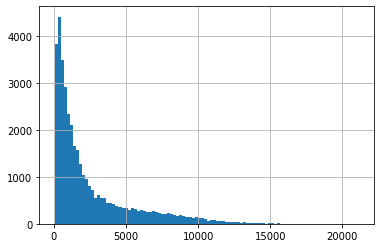

In [26]:
consults.txtlen.hist(bins=100)

In [33]:
consults.loc[consults.txtlen>200,['date', 'text']].to_parquet(output_folder+"/ODIN_CONSULTS.parquet")

# GENERIC DUTCH MEDICAL CORPORA

## NtVG

**33M words**

In [61]:
ntvg = pd.read_feather(r'T:\laupodteam\AIOS\Bram\language_modeling\MEDICAL_TEXT\RAW\NtvG\ntvg_articles.feather')

In [62]:
def concat_text(x):
    if isinstance(x, np.ndarray):
        if len(x)>=2:
            if len(x)==2:
                return x[1]+":"+x[0]
            elif len(x)==3:
                return x[1]+":"+x[0]+"\n"+x[2]
            elif len(x)>3:
                return "\n".join(x)
        else:
            return x
    else:
        return x
ntvg = ntvg.assign(text=ntvg.body_clean.apply(concat_text))
ntvg = ntvg.assign(category = ntvg.category.replace('Diagnose in beeld', 'Diagnose'))


In [63]:
ntvg = ntvg.assign(category = ntvg.category.astype('str'))
ntvg = ntvg.assign(domain = ntvg.domain.astype('str'))
ntvg = ntvg.assign(text = ntvg.text.astype('str'))

In [64]:
def concat_summaries(x):
    if x is not None:
        if isinstance(x, np.ndarray):
            return "\n".join(x)
        else:
            return ""
    else:
        return ""
ntvg = ntvg.assign(summary_text = "")
ntvg = ntvg.assign(summary_text = ntvg.summary_clean.apply(concat_summaries))

In [69]:
ntvg = ntvg.assign(total_text = ntvg[['text', 'summary_text']].apply(lambda x: "\n".join(x), axis=1))

In [70]:
ntvg[['category', 'domain', 'total_text']].to_parquet(output_folder+"/ntvg.parquet")
ntvg = ntvg.assign(num_contents = ntvg.body_clean.apply(lambda x: len(x)))
ntvg = ntvg.assign(txtlen=ntvg.total_text.str.split().apply(lambda x: len(x)))

In [71]:
ntvg.txtlen.sum()

33133048

In [ ]:
# concat with summary_clean, if available

## NHG

## HeNW

## Medical Wiki